# Data Storytelling

I have two datasets related to my capstone project, one contains hotel information, the other demographics through the US. Let's explore both separatedly to see hwat the data tells us.

****

## Demographics in the US

We have compiled a distribution of the population by ZIP code, with aggregates of age, gender, family size, and income. What are your expectations? We can imagine that most people live in cities, and we can have an idea of the age distribution. Let's plot all of these in some simple way.


In [1]:
# FIRST, import necessary modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# I want to be able to plot maps, so let's define a rather simple function able to do so...

def plotmapoutlines():
    df = pd.read_csv('StateKML.csv')
    us49 = df[df['id']!='AS']
    us49 = us49[us49['id']!='VI']
    us49 = us49[us49['id']!='MP']
    us49 = us49[us49['id']!='PR']
    us49 = us49[us49['id']!='AK']
    us49 = us49[us49['id']!='HI']
    us49 = us49[us49['id']!='GU']
    us49 = us49.reset_index(drop=True)
    
    #the states are defined. Let's clean it and store it in a list
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    listofboundaries_x = list()
    listofboundaries_y = list()
    
    for row in us49['geometry']:
        #replace < to > so that I can split it easily
        rs1 = row.replace('<','>').split('>')
        # find all coordinate blocks (because some states have 2 or more boundaries...)
        setofcoords = get_indexes("coordinates",rs1)
        # in every closed boundary
        for posinstr in setofcoords:
            # initialize
            xcoords = list()
            ycoords = list()
            #get the list of points defining the closed boundary
            coords = rs1[posinstr+1]
            # split it to get every x,y,z
            coords_split = coords.split(' ')
            # get every x and y
            for coord in coords_split:
                xyz = coord.split(',')
                xcoords.append(float(xyz[0]))
                ycoords.append(float(xyz[1]))
            # at the end of every set, I need to reappend the first to close it
            xcoords.append(xcoords[0])
            ycoords.append(ycoords[0])
            #add the newly created list to a master list of coordinates
            listofboundaries_x.append(xcoords)
            listofboundaries_y.append(ycoords)
    # all the boundaries are defined and store. BEar in mind MICHIGAN contains the lake, it won't look as nicely defined
    # as other maps... I should probably use other tools for this, but it is a simple way to have an initial description

    for indx in range(len(listofboundaries_x)):
        # for every set fo closed coordinates...
        plt.plot(listofboundaries_x[indx],listofboundaries_y[indx], 'k-',linewidth=0.5)

    # cool...
    plt.axis('off')
    
    
    

We are ready to continue. Extract the data and clean it

In [3]:
demograw = pd.read_csv('Demographics_best.csv',index_col=False)
for serie in demograw.columns.tolist():
    demograw[serie] = pd.to_numeric(demograw[serie], errors='coerce')

# there's only a few NANs, I can essentially get rid of them
demograw = demograw.dropna()
demograw.head()

Oh, we also need the latitude and longitude coordinates of the zip codes! Here they are:

In [4]:
ziplatlon = pd.read_csv('ziplatlon.csv',index_col=False)
demoglatlon = demograw.merge(ziplatlon, left_on='ZIP code', right_on='ZIP', how='inner')
demoglatlon = demoglatlon.drop('ZIP', axis=1)

# drop AK, HI, ...
# to do that I am going to filter the longitudes smaller than -124.5 and latitudes smaller than 24
demoglatlon = demoglatlon[demoglatlon['LNG']>-124.5]
demoglatlon = demoglatlon[demoglatlon['LAT']>24]

demoglatlon.head()

Let's start with some quantitate analysis:

* Distribution of population and wealth per zip code
* Age distributions

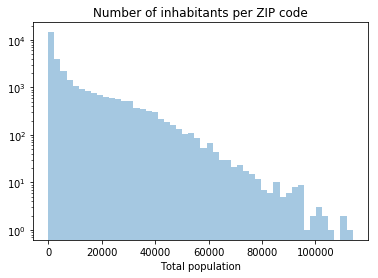

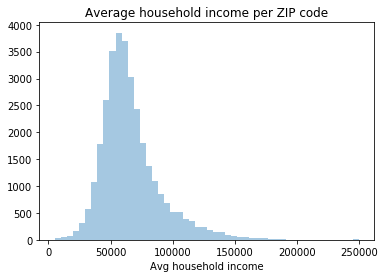

In [65]:
ax = sns.distplot(demoglatlon['Total population'], hist=True, kde=False, rug=False)
ax.set(yscale="log")
plt.title('Number of inhabitants per ZIP code')
plt.show()

ax = sns.distplot(demoglatlon['Avg household income'], hist=True, kde=False, rug=False)
#ax.set(yscale="log")
plt.title('Average household income per ZIP code')
plt.show()

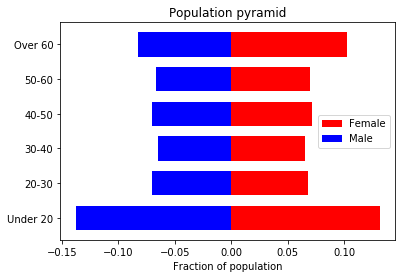

In [19]:
agedist = demoglatlon[['M – U20', 'M 20-30', 'M 30-40', 'M 40-50', 'M 50-60', 'M O60', 'F – U20', 'F 20-30', 'F 30-40', 'F 40-50', 'F 50-60', 'F O60']]
agedist2 = agedist.multiply(0.01*demoglatlon["Total population"], axis=0)

agedist3 = agedist2.sum()
totpop = agedist3.sum()
agedist3 = (agedist3/totpop).tolist()
males = agedist3[0:6]
females = agedist3[6:]
males = [(-1)*x for x in males]

plt.yticks(range(len(females)), ['Under 20', '20-30', '30-40', '40-50', '50-60', 'Over 60'])
plt.barh(range(len(females)),females, 0.7, color="red")
plt.barh(range(len(males)),males, 0.7, color="blue")
plt.legend(['Female', 'Male'], loc='right')
plt.xlabel('Fraction of population')
plt.title('Population pyramid')
plt.show()


As expected, the population distribution decays exponentially: most areas have a small number of inhabitants.

The average household income seems rather normal, with a mean around 55k USD, which indeed agrees with the national average


Let's look at spatial data

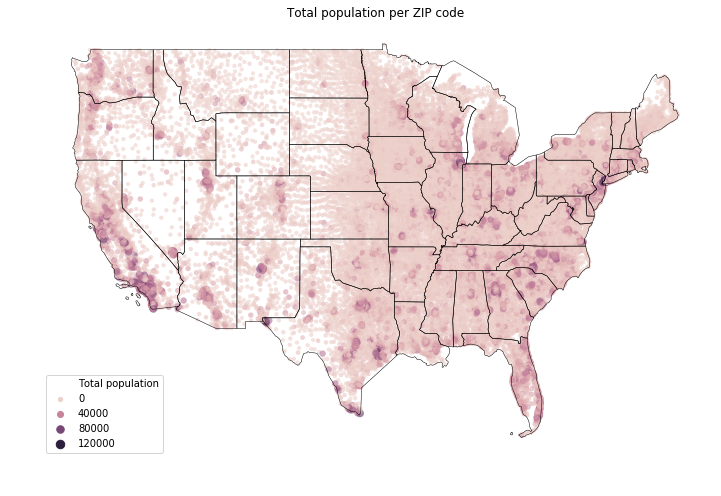

In [5]:
# the real thing... sctter by population
fig = plt.figure(figsize=(12,8))
plotmapoutlines()
sns.scatterplot(y='LAT', x='LNG', data=demoglatlon, hue='Total population', size='Total population', alpha=0.6, edgecolor='none')
plt.title('Total population per ZIP code')
plt.show()


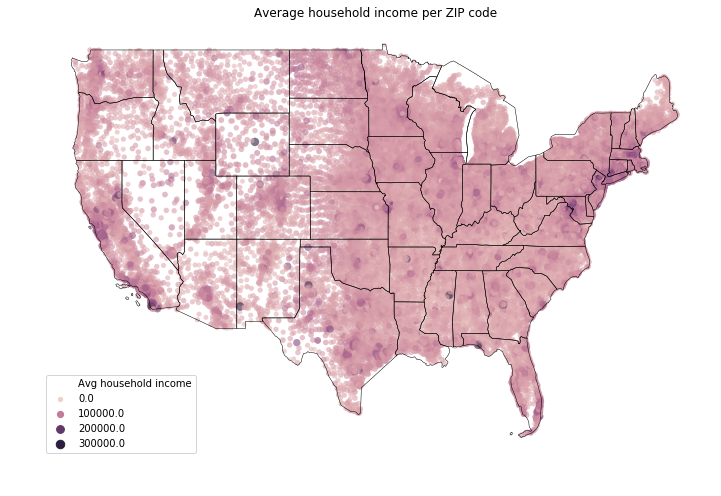

In [6]:
# the real thing... sctter by wealth! mean household income
fig = plt.figure(figsize=(12,8))
plotmapoutlines()
sns.scatterplot(y='LAT', x='LNG', data=demoglatlon, hue='Avg household income', size='Avg household income', alpha=0.6, edgecolor='none')
plt.title('Average household income per ZIP code')
plt.show()


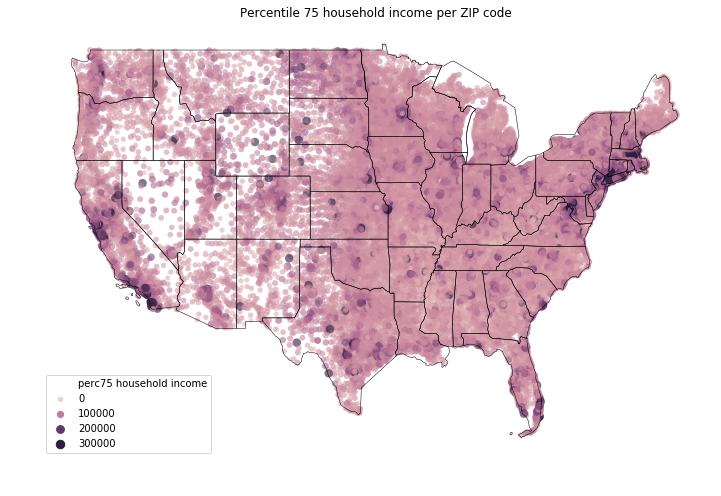

In [7]:
# the real thing... sctter by wealth! percentile 75 household income
fig = plt.figure(figsize=(12,8))
plotmapoutlines()
sns.scatterplot(y='LAT', x='LNG', data=demoglatlon, hue='perc75 household income', size='perc75 household income', alpha=0.6, edgecolor='none')
plt.title('Percentile 75 household income per ZIP code')
plt.show()

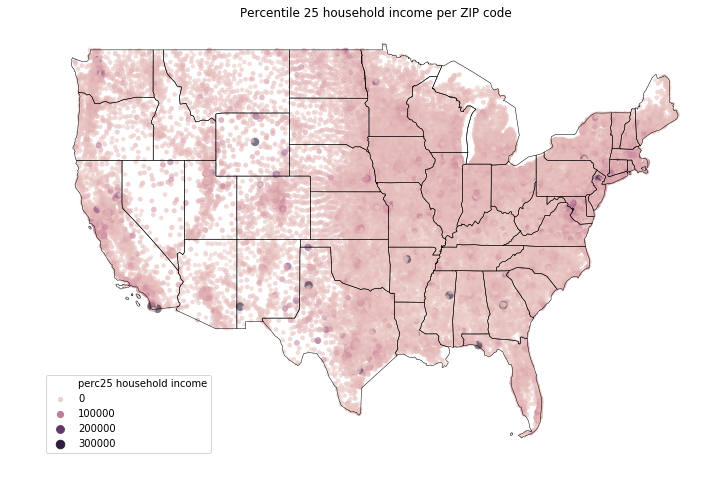

In [8]:
fig = plt.figure(figsize=(12,8))
plotmapoutlines()
sns.scatterplot(y='LAT', x='LNG', data=demoglatlon, hue='perc25 household income', size='perc25 household income', alpha=0.6, edgecolor='none')
plt.title('Percentile 25 household income per ZIP code')
plt.show()

### First observations

* The poor and middle class earn the same everywhere, the rich earn better near cities. Interesting, isn't it?
* How about the age distribution? Do youngsters live in cities, and the elderly in Florida?

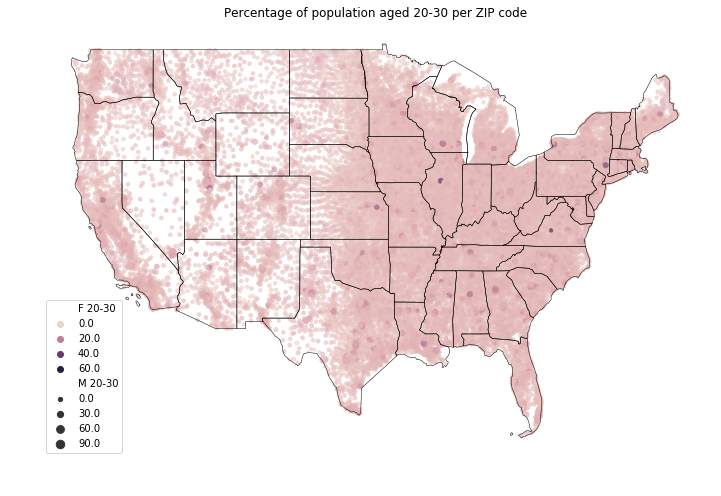

In [9]:
fig = plt.figure(figsize=(12,8))
plotmapoutlines()
sns.scatterplot(y='LAT', x='LNG', data=demoglatlon, hue='F 20-30', size='M 20-30', alpha=0.6, edgecolor='none')
plt.title('Percentage of population aged 20-30 per ZIP code')
plt.show()

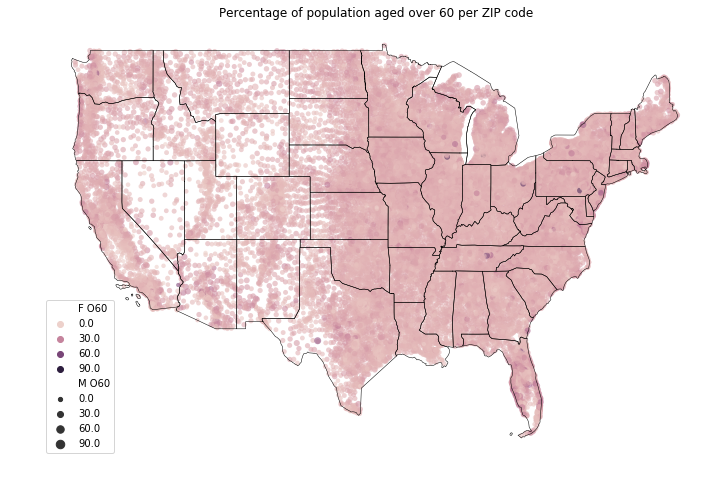

In [10]:
fig = plt.figure(figsize=(12,8))
plotmapoutlines()
sns.scatterplot(y='LAT', x='LNG', data=demoglatlon, hue='F O60', size='M O60', alpha=0.6, edgecolor='none')
plt.title('Percentage of population aged over 60 per ZIP code')
plt.show()

There does not seem to be a very strongly biased age distribution anywhere...

Let's look in more detail at whether the high-earning percentil-75 people correlates with population density:

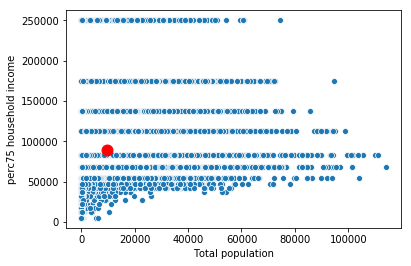

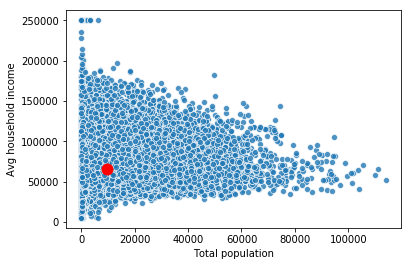

In [29]:
# I want to add here a centroid, or a trendline or something...

sns.scatterplot(x="Total population", y="perc75 household income", data=demoglatlon)
plt.scatter(np.mean(demoglatlon["Total population"]),np.mean(demoglatlon["perc75 household income"]), c='red', s = 120)
#ax.set(xscale="log", yscale="log")
plt.show()

sns.scatterplot(x="Total population", y="Avg household income", data=demoglatlon, alpha=0.8)
#ax.set(xscale="log", yscale="log")
plt.scatter(np.mean(demoglatlon["Total population"]),np.mean(demoglatlon["Avg household income"]), c='red', s = 120)
plt.show()

Well, this is not telling much quantitatively. The trend seems obvious to the eye, but not too significant statistically speaking

Let's finally see if clustering gives any additional insight

In [30]:
df2cluster = demoglatlon[['Total population', 'F 20-30', 'F O60', 'Average household size', 'Avg household income']]

from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(df2cluster, quantile=0.2, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(df2cluster)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 4


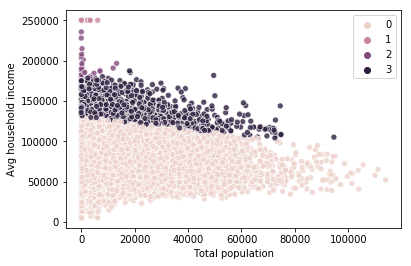

In [32]:
ax = sns.scatterplot(x="Total population", y="Avg household income", data=df2cluster, hue=labels, alpha=0.8)
plt.show()

Clearly the clustering goes by wealth, 1 are the wealthiest, followed by 2, 3, and 0 the poorest.

Let's plot it in the map

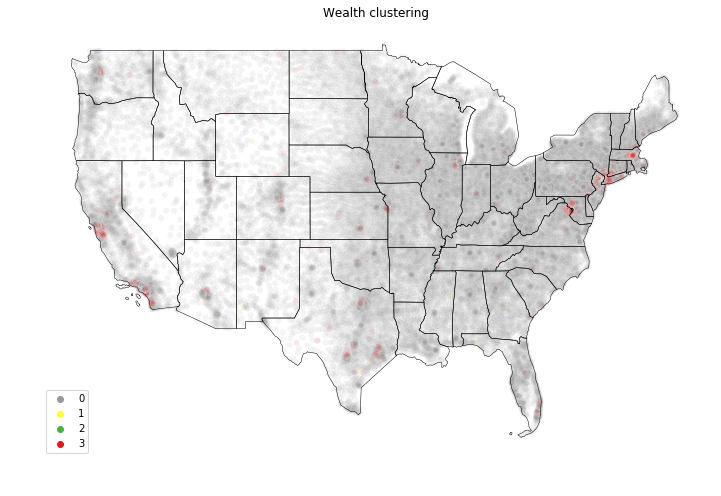

In [52]:
fig = plt.figure(figsize=(12,8))
plotmapoutlines()
sns.scatterplot(y='LAT', x='LNG', data=demoglatlon, hue=labels, alpha=0.1, palette='Set1_r')
plt.title('Wealth clustering')
plt.show()

We care about 1 and 2, right? Let's try to filter those out to improve the visuals

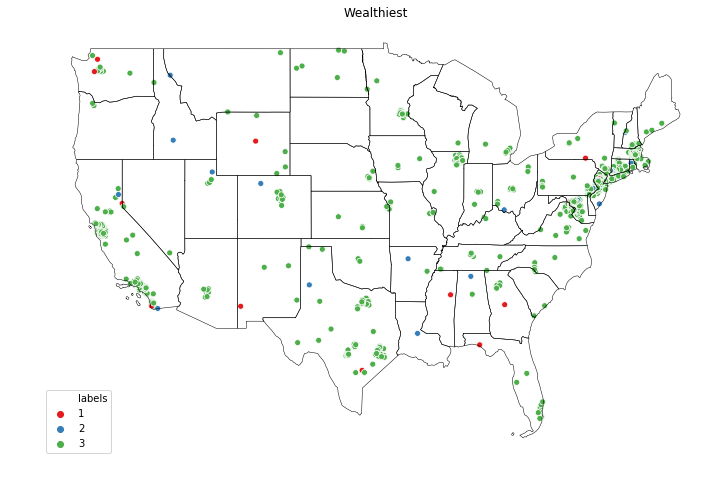

In [64]:
# add label columns in df
upperclass = demoglatlon.copy()
upperclass['labels']=labels
upperclass = upperclass[upperclass['labels']>0]


fig = plt.figure(figsize=(12,8))
plotmapoutlines()
sns.scatterplot(y='LAT', x='LNG', data=upperclass, hue='labels', palette=sns.color_palette('Set1',3))
plt.title('Wealthiest')
plt.show()

The wealthiest are in the most random places, such as:
* Center of WY
* Near Panama City, FL
* Near Macon, GA
* Near Tupelo, MS - Is Elvis involved?
* Near San Diego, CA
* ...

Meanwhile, the ones living well are consistently around the cities. Interesting!

Let's look at those megarich again...

In [67]:
rr = upperclass[upperclass['labels']<2]
rr

It seems clear after googling some of the locations that these points are erroneous! For instance:

* 82630 Arminto, WY: THe average household income according to some sources is less than the state average
* 39762 is Mississippi State University
* 64101 is a working class neighbourhood in Kansas City, MI

Hence, we should ignore these points! 

We conclude that the wealthiest areas are in metropolinitan regions.